# Analysis of SPAR primer design and primer features

SPAR (Selective PCR for Antibody Retreival) is a strategy for cloning antibodies in single cells within pooled sequence libraries. In this notebook, we analyze several aspects of SPAR, including:

1. Fraction of the human antibody repertoire that can be retrieved using SPAR.
2. Properties of SPAR primers related to PCR (such as melting temperature and position).

# Introduction

## Import packages

In [1]:
import sys
import os
import time
import glob
import Levenshtein
import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

## Set up display parameters

In [2]:
# Matplotlib parameters

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)

# Seaborn style
sns.set_style("ticks")

# Convenient function for saving figures as both PDF and PNG

savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}
mpl.rc('savefig', dpi=300)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

# Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 10000)

In [3]:
# Choose colors
color = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']

In [4]:
def reverse_complement(seq):
    """ Reverse complement of DNA sequence """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    rev_comp = "".join(complement.get(base, base) for base in reversed(seq))
    return rev_comp

# Load data (primer design results for entire human repertoire)

Data consists of a table which summarizes the results of SPAR primer design for each contig. Each row is a contig. Columns indicate features of the contig and primers designed to amplify the contig.

In [5]:
# Results are split up by sample
# Load all samples and aggregate into one dataframe

infile_dir = "/scratch/flu_singlecell/retrieval/data" # directory containing outputs from SPAR primer design pipeline
infiles = glob.glob(infile_dir + "/cell_contigs_primers.*.csv")
df_primers = pd.DataFrame()

for infile in infiles:
    df_temp = pd.read_csv(infile, header=0, index_col=0)
    df_primers = pd.concat([df_primers, df_temp])
    
print(df_primers.shape)
df_primers.head()

(94259, 124)


,sample,barcode,is_cell,contig_id_IGH,high_confidence_IGH,length_IGH,chain_IGH,full_length_IGH,productive_IGH,reads_IGH,umis_IGH,contig_id_IGKL,high_confidence_IGKL,length_IGKL,chain_IGKL,full_length_IGKL,productive_IGKL,reads_IGKL,umis_IGKL,IGH_pcr1_left_end_stability,IGH_pcr1_left_gc_percent,IGH_pcr1_left_hairpin_th,IGH_pcr1_left_length,IGH_pcr1_left_penalty,IGH_pcr1_left_position,IGH_pcr1_left_self_any_th,IGH_pcr1_left_self_end_th,IGH_pcr1_left_sequence,IGH_pcr1_left_tm,IGH_pcr1_pair_amplicon_sequence,IGH_pcr1_pair_compl_any_th,IGH_pcr1_pair_compl_end_th,IGH_pcr1_pair_penalty,IGH_pcr1_pair_product_size,IGH_pcr1_pair_umi,IGH_pcr1_right_end_stability,IGH_pcr1_right_gc_percent,IGH_pcr1_right_hairpin_th,IGH_pcr1_right_length,IGH_pcr1_right_penalty,IGH_pcr1_right_position,IGH_pcr1_right_self_any_th,IGH_pcr1_right_self_end_th,IGH_pcr1_right_sequence,IGH_pcr1_right_tm,IGH_pcr1_failure_cause,IGKL_pcr1_left_end_stability,IGKL_pcr1_left_gc_percent,IGKL_pcr1_left_hairpin_th,IGKL_pcr1_left_length,IGKL_pcr1_left_penalty,IGKL_pcr1_left_position,IGKL_pcr1_left_self_any_th,IGKL_pcr1_left_self_end_th,IGKL_pcr1_left_sequence,IGKL_pcr1_left_tm,IGKL_pcr1_pair_amplicon_sequence,IGKL_pcr1_pair_compl_any_th,IGKL_pcr1_pair_compl_end_th,IGKL_pcr1_pair_penalty,IGKL_pcr1_pair_product_size,IGKL_pcr1_pair_umi,IGKL_pcr1_right_end_stability,IGKL_pcr1_right_gc_percent,IGKL_pcr1_right_hairpin_th,IGKL_pcr1_right_length,IGKL_pcr1_right_penalty,IGKL_pcr1_right_position,IGKL_pcr1_right_self_any_th,IGKL_pcr1_right_self_end_th,IGKL_pcr1_right_sequence,IGKL_pcr1_right_tm,IGKL_pcr1_failure_cause,IGH_pcr2_left_end_stability,IGH_pcr2_left_gc_percent,IGH_pcr2_left_hairpin_th,IGH_pcr2_left_length,IGH_pcr2_left_penalty,IGH_pcr2_left_position,IGH_pcr2_left_self_any_th,IGH_pcr2_left_self_end_th,IGH_pcr2_left_sequence,IGH_pcr2_left_tm,IGH_pcr2_pair_compl_any_th,IGH_pcr2_pair_compl_end_th,IGH_pcr2_pair_penalty,IGH_pcr2_pair_product_size,IGH_pcr2_right_end_stability,IGH_pcr2_right_gc_percent,IGH_pcr2_right_hairpin_th,IGH_pcr2_right_length,IGH_pcr2_right_penalty,IGH_pcr2_right_position,IGH_pcr2_right_self_any_th,IGH_pcr2_right_self_end_th,IGH_pcr2_right_sequence,IGH_pcr2_right_tm,IGH_pcr2_failure_cause,IGKL_pcr2_left_end_stability,IGKL_pcr2_left_gc_percent,IGKL_pcr2_left_hairpin_th,IGKL_pcr2_left_length,IGKL_pcr2_left_penalty,IGKL_pcr2_left_position,IGKL_pcr2_left_self_any_th,IGKL_pcr2_left_self_end_th,IGKL_pcr2_left_sequence,IGKL_pcr2_left_tm,IGKL_pcr2_pair_compl_any_th,IGKL_pcr2_pair_compl_end_th,IGKL_pcr2_pair_penalty,IGKL_pcr2_pair_product_size,IGKL_pcr2_right_end_stability,IGKL_pcr2_right_gc_percent,IGKL_pcr2_right_hairpin_th,IGKL_pcr2_right_length,IGKL_pcr2_right_penalty,IGKL_pcr2_right_position,IGKL_pcr2_right_self_any_th,IGKL_pcr2_right_self_end_th,IGKL_pcr2_right_sequence,IGKL_pcr2_right_tm,IGKL_pcr2_failure_cause,success
73177,023-002_D7_Lane9,AAACCTGAGCTCCCAG-1,True,AAACCTGAGCTCCCAG-1_contig_3,True,544,IGH,True,True,2511,11,AAACCTGAGCTCCCAG-1_contig_2,True,643,IGL,True,True,4739,17,2.10,46.153846,32.767212,26.0,0.068039,22.0,16.909907,0.000000,AAACCTGAGCTCCCAGTCGTTTAGAA,67.068039,AAACCTGAGCTCCCAGTCGTTTAGAATTTCTTATATGGGTGGGGAAGGGAAATGCTTTCTGAGAGTCATGGACCTCCTGTGCAAGAACATGAAGCACCTGTGGTTTTTCCTCCTGCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTTACTCCATCAGCAGTGGTTACTACTGGAATTGGATCCGGCAGTCTCCAGGGAAGGGGCTGGAGTGGATTGGGAGTGTCTATCGTAGTGGGGGCACCTACTACAGCCCGTCCCTCAAGAGTCGACTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCATTTATTACTGTGCGAAAGAGAGTGGTGGTGACTGCTTGTTCTGTGCTTTTGATATCTGGGGCCACGGGACACTGGTCACCGTCTCTTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTC,18.558286,13.249295,4.151339,549.0,TCGTTTAGAA,3.77,60.869565,0.000000,23.0,4.083299,570.0,0.000000,0.000000,GAGACGAGGGGGAAAAGGGTTGG,68.083299,NaN,4.40,50.000000,36.164759,26.0,0.003377,18.0,16.909907,0.0,ATCTAAACCTGAGCTCCCAGTACAGC,67.003377,ATCTAAACCTGAGCTCCCAGTACAGCTCGGTTTCTTATATGGGGGGGCTGGGGTCTCAGGAGGCAGCGCTCTCGGGACGTCTCCACCATGGCCTGGGCTCTGCTATTCCT

# Generate amplicon sequences

In [6]:
# Amplicon sequences are generated by finding the left and right primers in the template for SPAR PCR2,
# then taking the substring that they encompass.

def rev_comp(seq):
    """ Make reverse complement of a DNA sequence """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    reverse_complement = "".join(complement.get(base, base) for base in reversed(seq))
    return reverse_complement

def amplicon(left_primer, right_primer, template):
    if isinstance(left_primer, basestring) and isinstance(right_primer, basestring) and isinstance(template, basestring):
        return template[template.find(left_primer):template.find(rev_comp(right_primer))+len(right_primer)]
    else:
        return None
    
IGH_pcr2_pair_amplicon_sequences = [amplicon(left_primer, right_primer, template) for left_primer, right_primer, template in zip(df_primers["IGH_pcr2_left_sequence"], df_primers["IGH_pcr2_right_sequence"], df_primers["IGH_pcr1_pair_amplicon_sequence"])]
IGKL_pcr2_pair_amplicon_sequences = [amplicon(left_primer, right_primer, template) for left_primer, right_primer, template in zip(df_primers["IGKL_pcr2_left_sequence"], df_primers["IGKL_pcr2_right_sequence"], df_primers["IGKL_pcr1_pair_amplicon_sequence"])]

df_primers["IGH_pcr2_pair_amplicon_sequence"] = IGH_pcr2_pair_amplicon_sequences
df_primers["IGKL_pcr2_pair_amplicon_sequence"] = IGKL_pcr2_pair_amplicon_sequences

# Inspect number of cells per library

In [7]:
df_primers["sample"].value_counts()

023-002_D7_Lane10    7169
023-002_D7_Lane1     7043
023-002_D7_Lane9     6866
023-002_D7_Lane11    6852
023-002_D7_Lane2     6759
023-002_D7_Lane3     6645
023-002_D7_Lane7     6572
023-002_D7_Lane6     6542
023-002_D7_Lane4     6522
023-002_D7_Lane8     6495
023-002_D7_Lane5     6398
023-002_D7_Lane12    6180
023-002_D9_Lane4     5043
023-002_D9_Lane3     4750
023-002_D9_Lane2     4125
023-002_D9_Lane1      298
Name: sample, dtype: int64

In [8]:
print np.mean(df_primers["sample"].value_counts())
print np.std(df_primers["sample"].value_counts())

5891.1875
1668.9999332965085


In [9]:
# Exclude failed library
df_primers["sample"].value_counts()[:-1]

023-002_D7_Lane10    7169
023-002_D7_Lane1     7043
023-002_D7_Lane9     6866
023-002_D7_Lane11    6852
023-002_D7_Lane2     6759
023-002_D7_Lane3     6645
023-002_D7_Lane7     6572
023-002_D7_Lane6     6542
023-002_D7_Lane4     6522
023-002_D7_Lane8     6495
023-002_D7_Lane5     6398
023-002_D7_Lane12    6180
023-002_D9_Lane4     5043
023-002_D9_Lane3     4750
023-002_D9_Lane2     4125
Name: sample, dtype: int64

In [10]:
print np.mean(df_primers["sample"].value_counts()[:-1])
print np.std(df_primers["sample"].value_counts()[:-1])

6264.066666666667
864.0849855322232


# Inspect failure modes leading to unretrievable antibodies

In [11]:
# Inspect failures
columns = [x for x in list(df_primers.columns) if "failure" in x] + ["success"]
df_primers[columns].head(n=10)

,IGH_pcr1_failure_cause,IGKL_pcr1_failure_cause,IGH_pcr2_failure_cause,IGKL_pcr2_failure_cause,success
73177,NaN,NaN,NaN,NaN,True
73178,NaN,NaN,NaN,NaN,True
73179,NaN,NaN,NaN,NaN,True
73180,NaN,NaN,NaN,NaN,True
73181,NaN,NaN,NaN,NaN,True
73182,NaN,NaN,no_primer_found~IGH_pcr2,NaN,False
73183,NaN,NaN,NaN,NaN,True
73184,NaN,NaN,NaN,NaN,True
73185,NaN,NaN,NaN,NaN,True
73186,NaN,NaN,no_primer_found~IGH_pcr2,no_primer_found~IGKL_pcr2,False


In [12]:
df_primers["IGH_pcr1_failure_cause"].value_counts(dropna=False)

NaN                           89864
no_primer_found~IGH_pcr1       3953
no_C_region_match~IGH_pcr1      442
Name: IGH_pcr1_failure_cause, dtype: int64

In [13]:
df_primers["IGKL_pcr1_failure_cause"].value_counts(dropna=False)

NaN                            90803
no_primer_found~IGKL_pcr1       3366
no_C_region_match~IGKL_pcr1       90
Name: IGKL_pcr1_failure_cause, dtype: int64

In [14]:
df_primers["IGH_pcr2_failure_cause"].value_counts(dropna=False)

NaN                         82906
no_primer_found~IGH_pcr2     6958
pcr1_failed~IGH_pcr2         4395
Name: IGH_pcr2_failure_cause, dtype: int64

In [15]:
df_primers["IGKL_pcr2_failure_cause"].value_counts(dropna=False)

NaN                          84404
no_primer_found~IGKL_pcr2     6399
pcr1_failed~IGKL_pcr2         3456
Name: IGKL_pcr2_failure_cause, dtype: int64

In [16]:
df_primers["success"].value_counts()

True     76781
False    17478
Name: success, dtype: int64

In [17]:
df_primers["success"].value_counts(normalize=True)

True     0.814575
False    0.185425
Name: success, dtype: float64

# Visualize addressability

In [18]:
## Prepare data: calculate success rates in each category, create summary columns

# Summary columns
df_primers["Valid IGH TDR primers"] = pd.isnull(df_primers["IGH_pcr1_failure_cause"])
df_primers["Valid IGKL TDR primers"] = pd.isnull(df_primers["IGKL_pcr1_failure_cause"])

df_primers["Valid IGH cloning primers"] = pd.isnull(df_primers["IGH_pcr2_failure_cause"])
df_primers["Valid IGKL cloning primers"] = pd.isnull(df_primers["IGKL_pcr2_failure_cause"])

df_primers["Valid IGH AND IGKL TDR primers"] = (df_primers["Valid IGH TDR primers"] & df_primers["Valid IGKL TDR primers"])
df_primers["Valid IGH AND IGKL cloning primers"] = (df_primers["Valid IGH cloning primers"] & df_primers["Valid IGKL cloning primers"])

In [19]:
# Get summary columns
columns_Valid = [x for x in list(df_primers.columns) if "Valid" in x]
df_primers_summary = df_primers[columns_Valid]

# Reorder columns
columns_reordered = ["Valid IGH TDR primers", "Valid IGKL TDR primers", "Valid IGH AND IGKL TDR primers", "Valid IGH cloning primers", "Valid IGKL cloning primers", "Valid IGH AND IGKL cloning primers"]
df_primers_summary = df_primers_summary[columns_reordered]

# Inspect summary columns
df_primers_summary.head(n=10)

,Valid IGH TDR primers,Valid IGKL TDR primers,Valid IGH AND IGKL TDR primers,Valid IGH cloning primers,Valid IGKL cloning primers,Valid IGH AND IGKL cloning primers
73177,True,True,True,True,True,True
73178,True,True,True,True,True,True
73179,True,True,True,True,True,True
73180,True,True,True,True,True,True
73181,True,True,True,True,True,True
73182,True,True,True,False,True,False
73183,True,True,True,True,True,True
73184,True,True,True,True,True,True
73185,True,True,True,True,True,True
73186,True,True,True,False,False,False


In [20]:
# Calculate success rates in each category
df_addr_frac = df_primers_summary.mean() * 100 # percent addressable
df_addr_count = df_primers_summary.sum()

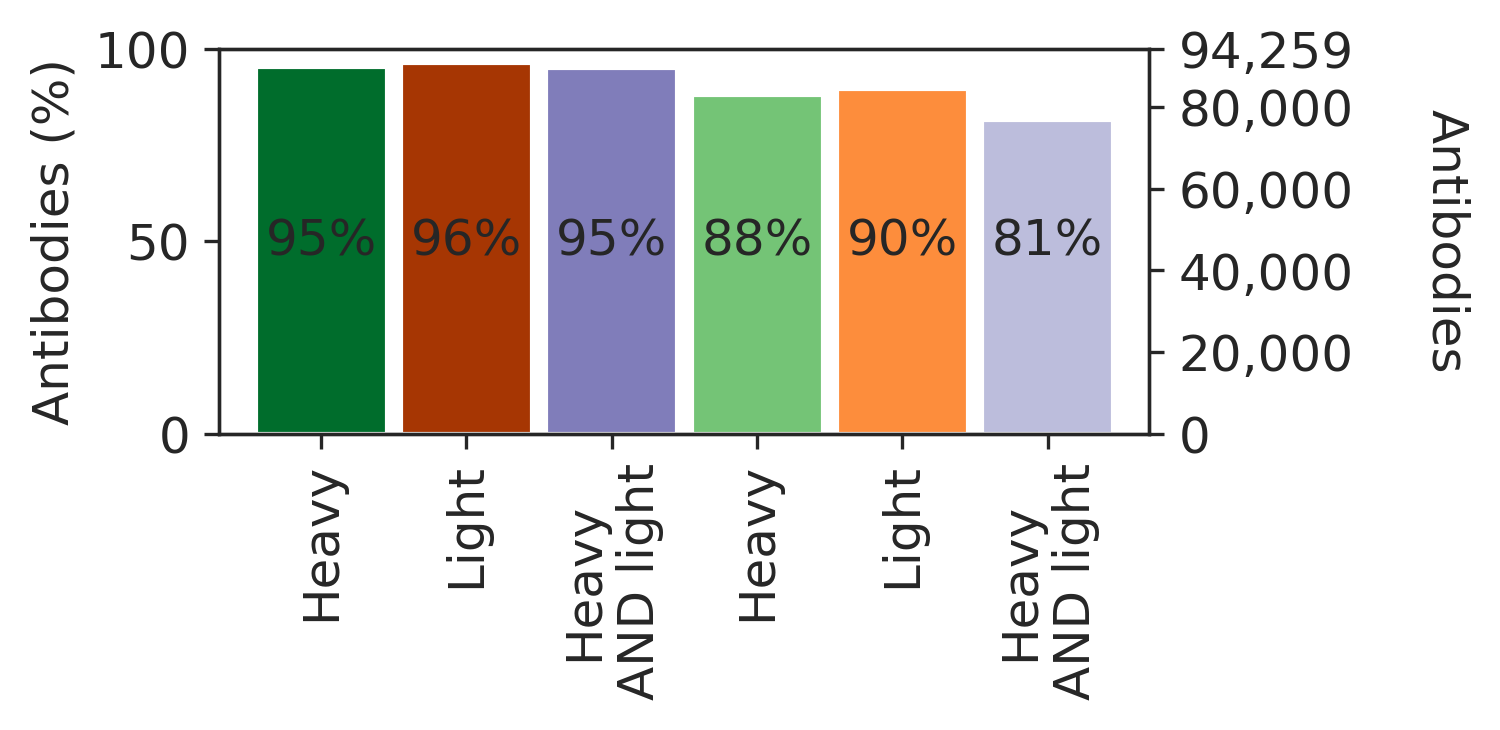

In [21]:
columns = ["Valid IGH TDR primers", "Valid IGKL TDR primers", "Valid IGH AND IGKL TDR primers",
           "Valid IGH cloning primers", "Valid IGKL cloning primers", "Valid IGH AND IGKL cloning primers"]

palette = ["#006d2c", "#a63603", "#807dba", "#74c476", "#fd8d3c", "#bcbddc"]

fig, ax = plt.subplots(1, 1, figsize=(4,1.7))

df_addr_frac[columns].plot(kind="bar", ax=ax, width=0.9, color=palette)

ax.set_ylim(0, 100)
ax.set_ylabel("Antibodies (%)")
# xticklabels = ["Valid IGH\nTDR primers", "Valid IGKL\nTDR primers", "Valid IGH AND IGKL\nTDR primers",
#                "Valid IGH\ncloning primers", "Valid IGKL\ncloning primers", "Valid IGH AND IGKL\ncloning primers"]
xticklabels = ["Heavy", "Light", "Heavy\nAND light",
               "Heavy", "Light", "Heavy\nAND light"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center")

# add second axis
ax2 = ax.twinx()
yticks = [0, 2e4, 4e4, 6e4, 8e4, df_primers.shape[0]]
ax2.set_yticks(yticks)
yticklabels = [0, "20,000", "40,000", "60,000", "80,000", "94,259"]
ax2.set_yticklabels(yticklabels)
ax2.set_ylabel("Antibodies", rotation=270, labelpad=28)

# text labels on bars
for i, (_, val) in enumerate(df_addr_frac.iteritems()):
    ax.text(i, 50, '{0:.0f}%'.format(val), ha="center", va="center")
    
save_figure(fig, "SPAR_addressability")

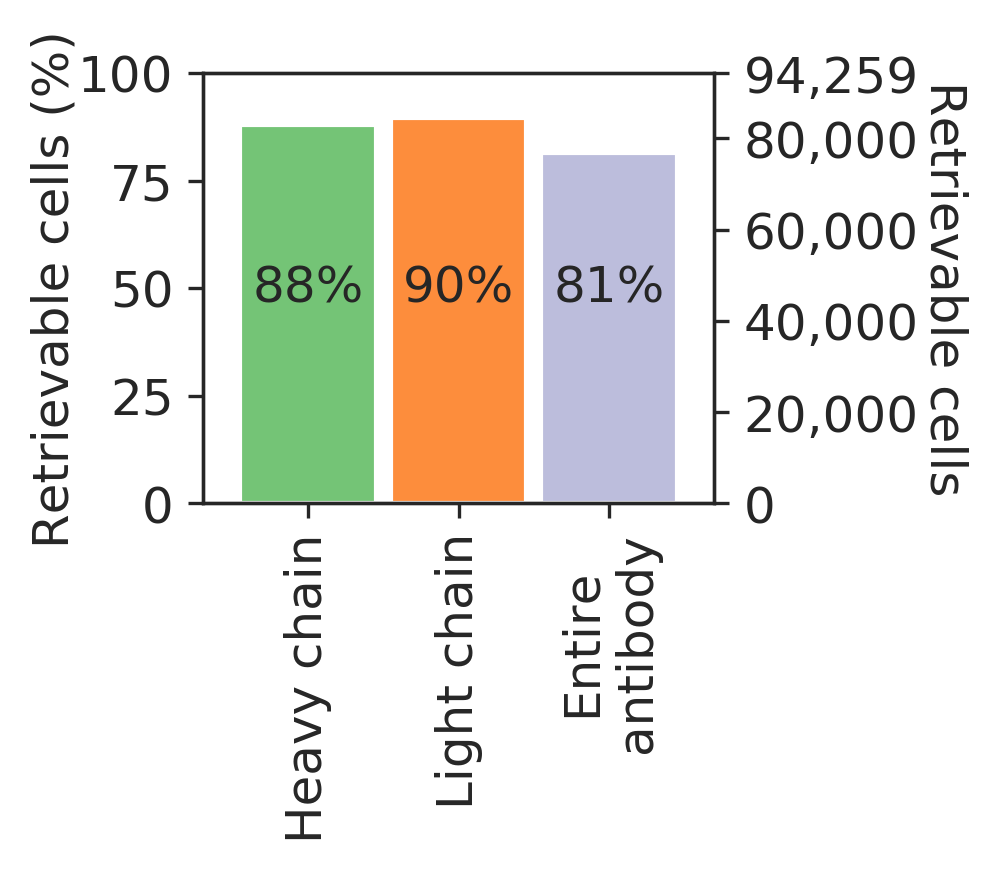

In [22]:
# Plot again more simply

columns = ["Valid IGH cloning primers", "Valid IGKL cloning primers", "Valid IGH AND IGKL cloning primers"]


palette = ["#74c476", "#fd8d3c", "#bcbddc"]

fig, ax = plt.subplots(1, 1, figsize=(2.2,1.9))

df_addr_frac[columns].plot(kind="bar", ax=ax, width=0.9, color=palette)

ax.set_ylim(0, 100)
ax.set_ylabel("Retrievable cells (%)", labelpad=0)
# xticklabels = ["Valid IGH\nTDR primers", "Valid IGKL\nTDR primers", "Valid IGH AND IGKL\nTDR primers",
#                "Valid IGH\ncloning primers", "Valid IGKL\ncloning primers", "Valid IGH AND IGKL\ncloning primers"]
xticklabels = ["Heavy chain", "Light chain", "Entire\nantibody"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center")

# add second axis
ax2 = ax.twinx()
yticks = [0, 2e4, 4e4, 6e4, 8e4, df_primers.shape[0]]
ax2.set_yticks(yticks)
yticklabels = [0, "20,000", "40,000", "60,000", "80,000", "94,259"]
ax2.set_yticklabels(yticklabels)
ax2.set_ylabel("Retrievable cells", rotation=270, labelpad=12)

# text labels on bars
for i, (_, val) in enumerate(df_addr_frac[columns].iteritems()):
    ax.text(i, 50, '{0:.0f}%'.format(val), ha="center", va="center")
    
save_figure(fig, "SPAR_addressability_simple")

# Visualize properties of selected primers (Tm, position, product size)

In [23]:
# List attributes (useful for copying column names)
for x in list(df_primers.columns):
    print x

sample
barcode
is_cell
contig_id_IGH
high_confidence_IGH
length_IGH
chain_IGH
full_length_IGH
productive_IGH
reads_IGH
umis_IGH
contig_id_IGKL
high_confidence_IGKL
length_IGKL
chain_IGKL
full_length_IGKL
productive_IGKL
reads_IGKL
umis_IGKL
IGH_pcr1_left_end_stability
IGH_pcr1_left_gc_percent
IGH_pcr1_left_hairpin_th
IGH_pcr1_left_length
IGH_pcr1_left_penalty
IGH_pcr1_left_position
IGH_pcr1_left_self_any_th
IGH_pcr1_left_self_end_th
IGH_pcr1_left_sequence
IGH_pcr1_left_tm
IGH_pcr1_pair_amplicon_sequence
IGH_pcr1_pair_compl_any_th
IGH_pcr1_pair_compl_end_th
IGH_pcr1_pair_penalty
IGH_pcr1_pair_product_size
IGH_pcr1_pair_umi
IGH_pcr1_right_end_stability
IGH_pcr1_right_gc_percent
IGH_pcr1_right_hairpin_th
IGH_pcr1_right_length
IGH_pcr1_right_penalty
IGH_pcr1_right_position
IGH_pcr1_right_self_any_th
IGH_pcr1_right_self_end_th
IGH_pcr1_right_sequence
IGH_pcr1_right_tm
IGH_pcr1_failure_cause
IGKL_pcr1_left_end_stability
IGKL_pcr1_left_gc_percent
IGKL_pcr1_left_hairpin_th
IGKL_pcr1_left_lengt

In [24]:
# Set color here for consistency across all plots below
color = ["#006d2c", "#a63603", "#54278f", "#74c476", "#fd8d3c", "#9e9ac8"]

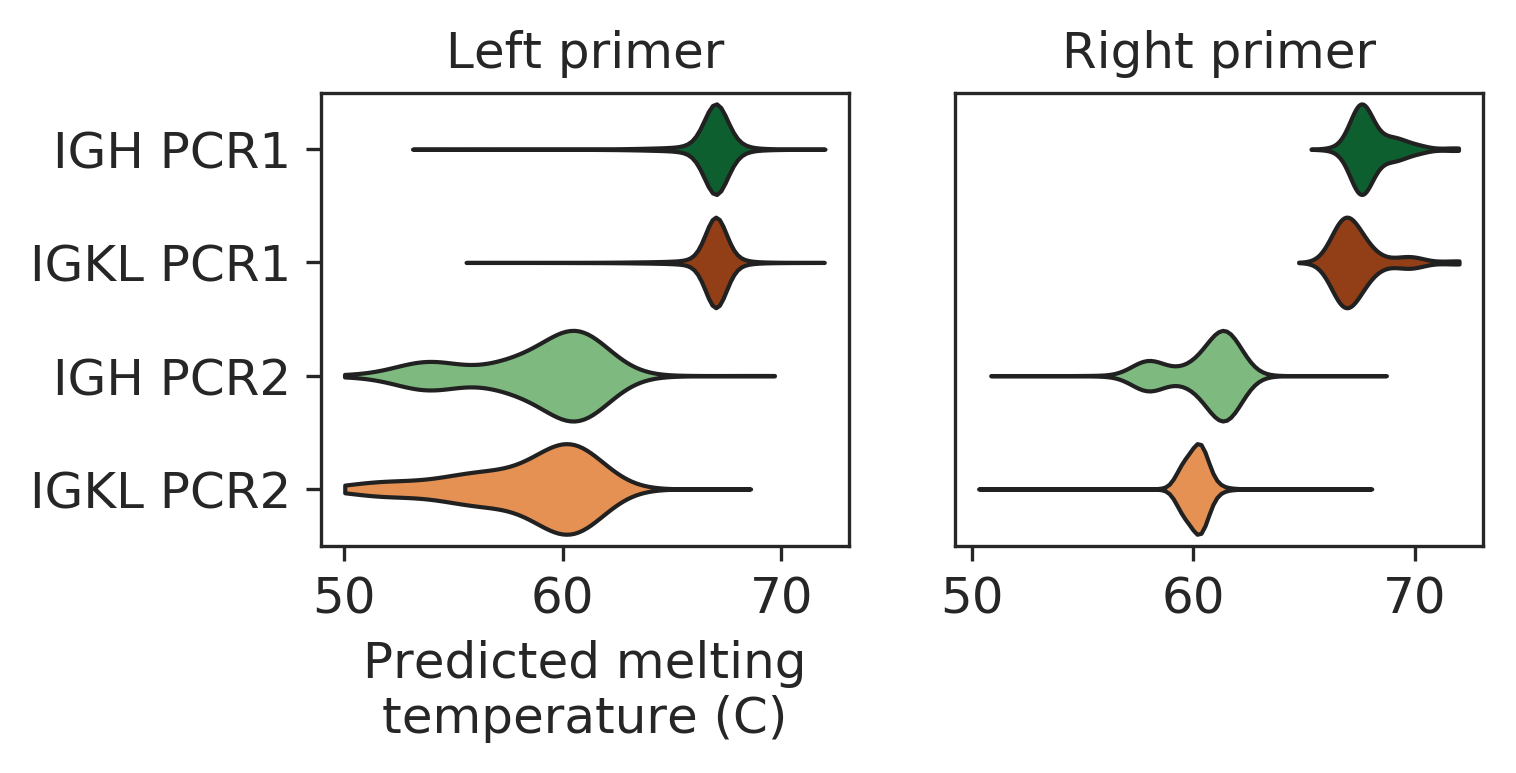

In [25]:
# Tm

palette = [color[0], color[1], color[3], color[4]]

fig, axes = plt.subplots(1, 2, figsize=(5,2))

x1 = df_primers["IGH_pcr1_left_tm"]
x2 = df_primers["IGKL_pcr1_left_tm"]
x3 = df_primers["IGH_pcr2_left_tm"]
x4 = df_primers["IGKL_pcr2_left_tm"]
data = [x1, x2, x3, x4]

ax = axes[0]
sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

x1 = df_primers["IGH_pcr1_right_tm"]
x2 = df_primers["IGKL_pcr1_right_tm"]
x3 = df_primers["IGH_pcr2_right_tm"]
x4 = df_primers["IGKL_pcr2_right_tm"]
data2 = [x1, x2, x3, x4]

ax = axes[1]
sns.violinplot(ax=ax, data=data2, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

axes[0].set_title("Left primer")
axes[1].set_title("Right primer")

yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
axes[0].set_yticklabels(yticklabels)
axes[1].set_yticks([])

axes[0].set_xlabel("Predicted melting\ntemperature (C)")

save_figure(fig, "SPAR_Tm")

(76781, 132)


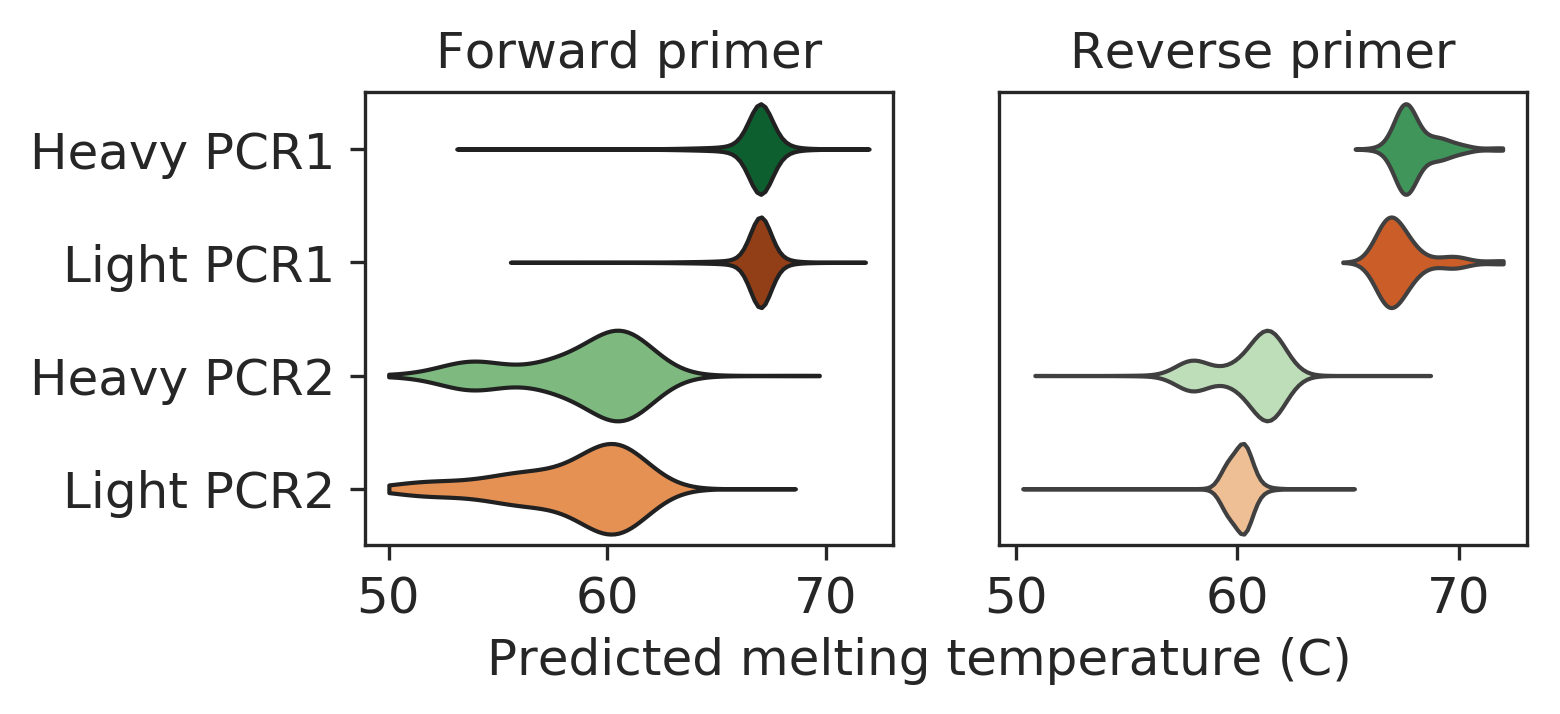

In [26]:
# Tm of valid SPAR primers

# Filter for cells having valid IGH and IGKL primers
df_temp = df_primers.loc[df_primers["Valid IGH AND IGKL cloning primers"] == True]
print df_temp.shape

palette = [color[0], color[1], color[3], color[4]]

fig, axes = plt.subplots(1, 2, figsize=(5,2))

x1 = df_temp["IGH_pcr1_left_tm"]
x2 = df_temp["IGKL_pcr1_left_tm"]
x3 = df_temp["IGH_pcr2_left_tm"]
x4 = df_temp["IGKL_pcr2_left_tm"]
data = [x1, x2, x3, x4]

ax = axes[0]
palette = [color[0], color[1], color[3], color[4]]
sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

x1 = df_temp["IGH_pcr1_right_tm"]
x2 = df_temp["IGKL_pcr1_right_tm"]
x3 = df_temp["IGH_pcr2_right_tm"]
x4 = df_temp["IGKL_pcr2_right_tm"]
data2 = [x1, x2, x3, x4]

ax = axes[1]
palette = ['#31a354', '#e6550d', '#bae4b3', '#fdbe85']
sns.violinplot(ax=ax, data=data2, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

axes[0].set_title("Forward primer")
axes[1].set_title("Reverse primer")

yticklabels = ["Heavy PCR1", "Light PCR1", "Heavy PCR2", "Light PCR2"]
axes[0].set_yticklabels(yticklabels)
axes[1].set_yticks([])

axes[0].set_xlabel("Predicted melting temperature (C)")
axes[0].xaxis.set_label_coords(1.05, -0.2)

save_figure(fig, "SPAR_Tm_valid")

In [27]:
# Show median, mean, and standard deviation of Tm

data_temp = [list(data[0]) + list(data[1]) + list(data2[0]) + list(data2[1])]
print "PCR1"
print np.nanmedian(data_temp), np.nanmean(data_temp), np.nanstd(data_temp)
print

data_temp = [list(data[2]) + list(data[3]) + list(data2[2]) + list(data2[3])]
print "PCR2"
print np.nanmedian(data_temp), np.nanmean(data_temp), np.nanstd(data_temp)
print


PCR1
67.05926332799993 67.3125256882055 1.110368130981525

PCR2
60.2557904951546 59.37824193775483 2.3795148165496536



In [28]:
# Report median Tm difference

df_temp = df_primers.loc[df_primers["Valid IGH AND IGKL cloning primers"] == True]

x1 = np.abs(df_temp["IGH_pcr1_left_tm"] - df_temp["IGH_pcr1_right_tm"])
x2 = np.abs(df_temp["IGKL_pcr1_left_tm"] - df_temp["IGKL_pcr1_right_tm"])
x3 = np.abs(df_temp["IGH_pcr2_left_tm"] - df_temp["IGH_pcr2_right_tm"])
x4 = np.abs(df_temp["IGKL_pcr2_left_tm"] - df_temp["IGKL_pcr2_right_tm"])

data = map(list, [x1, x2, x3, x4])

for x in data:
    print np.nanmedian(x)

print

data_temp = [data[0] + data[1]]
print "PCR1"
print np.nanmedian(data_temp), np.nanmean(data_temp), np.nanstd(data_temp)
print

data_temp = [data[2] + data[3]]
print "PCR2"
print np.nanmedian(data_temp), np.nanmean(data_temp), np.nanstd(data_temp)
print

0.748410308768996
0.4285843252449695
1.5683662264482265
1.1162735368174523

PCR1
0.5938991439344363 1.1201301814151117 1.260092242703095

PCR2
1.2829351673883274 2.496932311670073 2.5984112509717097



0 0.748410308768996 1.2770745257749903
1 0.4285843252449695 1.2172943785613906
2 1.5683662264482265 2.5648990341607414
3 1.1162735368174523 2.618042369287097


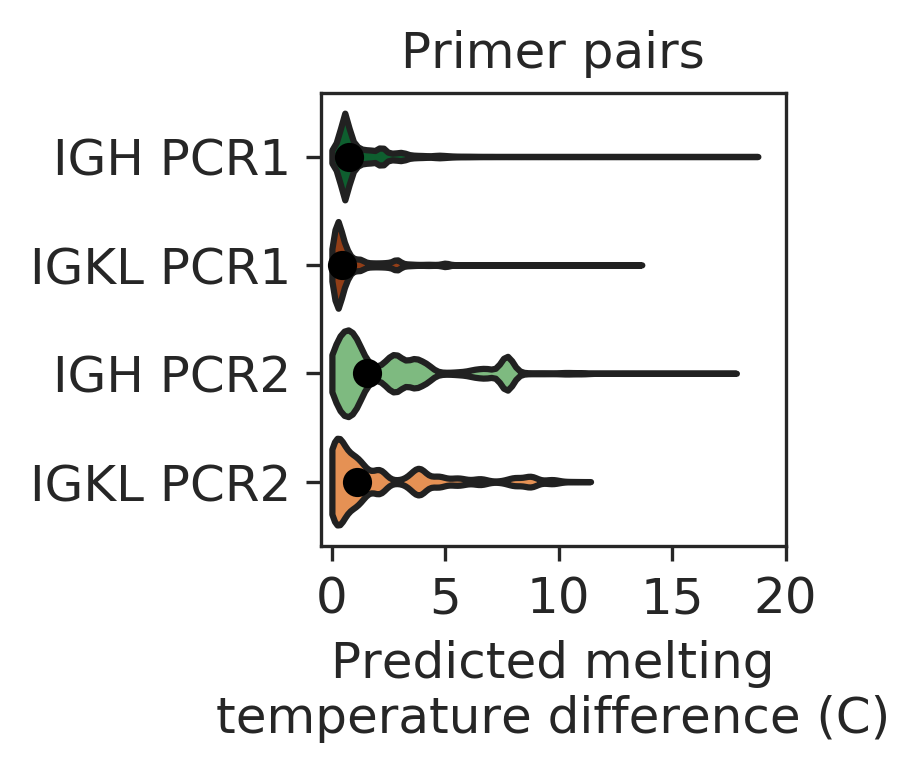

In [29]:
# Difference in predicted melting temperature

color = ["#006d2c", "#a63603", "#54278f", "#74c476", "#fd8d3c", "#9e9ac8"]
palette = [color[0], color[1], color[3], color[4]]

fig, ax = plt.subplots(1, 1, figsize=(2,2))
sns.violinplot(ax=ax, data=data, orient="h", cut=0, inner=None, scale="width", palette=palette)
ax.set_xlim(-0.5, 20)
ax.set_xlabel("Predicted melting\ntemperature difference (C)")
yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
ax.set_yticklabels(yticklabels)
ax.set_xticks([0, 5, 10, 15, 20])
for i, x in enumerate(data):
    print i, np.nanmedian(x), np.nanstd(x)
    ax.scatter(np.nanmedian(x), i, c="k")
ax.set_title("Primer pairs")

save_figure(fig, "SPAR_Tm_difference_valid")

0 0.748410308768996 1.2770745257749903
1 0.4285843252449695 1.2172943785613906
2 1.5683662264482265 2.5648990341607414
3 1.1162735368174523 2.618042369287097


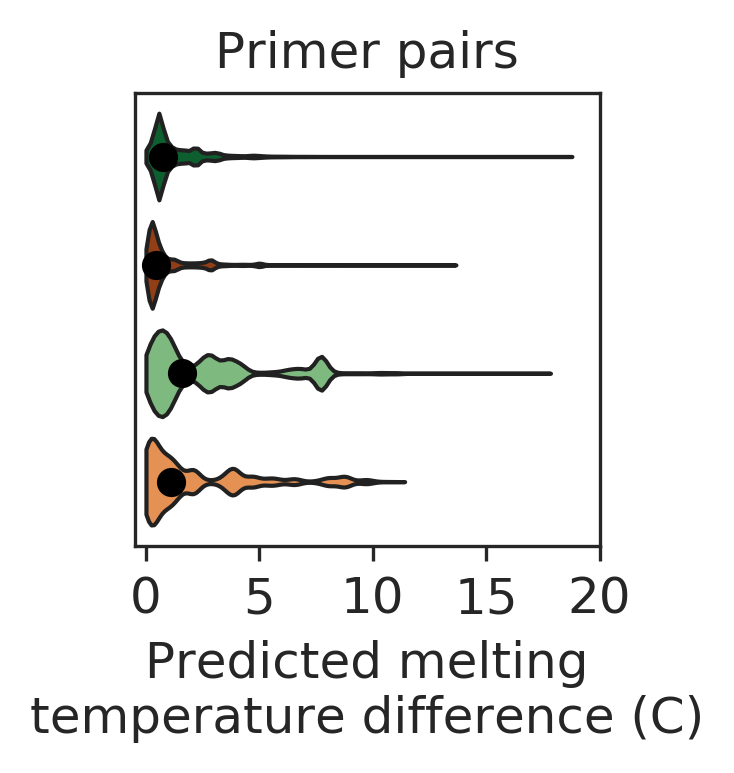

In [30]:
# Difference in predicted melting temperature (no yticklabels)

color = ["#006d2c", "#a63603", "#54278f", "#74c476", "#fd8d3c", "#9e9ac8"]
palette = [color[0], color[1], color[3], color[4]]

fig, ax = plt.subplots(1, 1, figsize=(2,2))
sns.violinplot(ax=ax, data=data, orient="h", cut=0, inner=None, scale="width", palette=palette, linewidth=1)
ax.set_xlim(-0.5, 20)
ax.set_xlabel("Predicted melting\ntemperature difference (C)")
# yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
ax.set_yticks([])
ax.set_xticks([0, 5, 10, 15, 20])
for i, x in enumerate(data):
    print i, np.nanmedian(x), np.nanstd(x)
    ax.scatter(np.nanmedian(x), i, c="k")
ax.set_title("Primer pairs")

save_figure(fig, "SPAR_Tm_difference_valid_noyticklabels")

# Examine orthogonality of primers (distance to nearest primer)

In [31]:
# Calculate pairwise distance between primers

def pairwise_Levenshtein(L):
    D = np.empty((len(L), len(L)))
    D[:] = np.nan
    for i, s1 in enumerate(L):
        for j, s2 in enumerate(L):
            if i >= j: continue
            D[i,j] = Levenshtein.distance(s1, s2)
            D[j,i] = D[i,j]
    return D

In [32]:
# Pick a lane for testing
df_temp = df_primers.loc[df_primers["Valid IGH AND IGKL cloning primers"] == True]                         
df_temp = df_temp.loc[df_temp["sample"] == df_temp["sample"].iloc[0]]
print df_temp.shape
df_temp.head()

(5647, 132)


,sample,barcode,is_cell,contig_id_IGH,high_confidence_IGH,length_IGH,chain_IGH,full_length_IGH,productive_IGH,reads_IGH,umis_IGH,contig_id_IGKL,high_confidence_IGKL,length_IGKL,chain_IGKL,full_length_IGKL,productive_IGKL,reads_IGKL,umis_IGKL,IGH_pcr1_left_end_stability,IGH_pcr1_left_gc_percent,IGH_pcr1_left_hairpin_th,IGH_pcr1_left_length,IGH_pcr1_left_penalty,IGH_pcr1_left_position,IGH_pcr1_left_self_any_th,IGH_pcr1_left_self_end_th,IGH_pcr1_left_sequence,IGH_pcr1_left_tm,IGH_pcr1_pair_amplicon_sequence,IGH_pcr1_pair_compl_any_th,IGH_pcr1_pair_compl_end_th,IGH_pcr1_pair_penalty,IGH_pcr1_pair_product_size,IGH_pcr1_pair_umi,IGH_pcr1_right_end_stability,IGH_pcr1_right_gc_percent,IGH_pcr1_right_hairpin_th,IGH_pcr1_right_length,IGH_pcr1_right_penalty,IGH_pcr1_right_position,IGH_pcr1_right_self_any_th,IGH_pcr1_right_self_end_th,IGH_pcr1_right_sequence,IGH_pcr1_right_tm,IGH_pcr1_failure_cause,IGKL_pcr1_left_end_stability,IGKL_pcr1_left_gc_percent,IGKL_pcr1_left_hairpin_th,IGKL_pcr1_left_length,IGKL_pcr1_left_penalty,IGKL_pcr1_left_position,IGKL_pcr1_left_self_any_th,IGKL_pcr1_left_self_end_th,IGKL_pcr1_left_sequence,IGKL_pcr1_left_tm,IGKL_pcr1_pair_amplicon_sequence,IGKL_pcr1_pair_compl_any_th,IGKL_pcr1_pair_compl_end_th,IGKL_pcr1_pair_penalty,IGKL_pcr1_pair_product_size,IGKL_pcr1_pair_umi,IGKL_pcr1_right_end_stability,IGKL_pcr1_right_gc_percent,IGKL_pcr1_right_hairpin_th,IGKL_pcr1_right_length,IGKL_pcr1_right_penalty,IGKL_pcr1_right_position,IGKL_pcr1_right_self_any_th,IGKL_pcr1_right_self_end_th,IGKL_pcr1_right_sequence,IGKL_pcr1_right_tm,IGKL_pcr1_failure_cause,IGH_pcr2_left_end_stability,IGH_pcr2_left_gc_percent,IGH_pcr2_left_hairpin_th,IGH_pcr2_left_length,IGH_pcr2_left_penalty,IGH_pcr2_left_position,IGH_pcr2_left_self_any_th,IGH_pcr2_left_self_end_th,IGH_pcr2_left_sequence,IGH_pcr2_left_tm,IGH_pcr2_pair_compl_any_th,IGH_pcr2_pair_compl_end_th,IGH_pcr2_pair_penalty,IGH_pcr2_pair_product_size,IGH_pcr2_right_end_stability,IGH_pcr2_right_gc_percent,IGH_pcr2_right_hairpin_th,IGH_pcr2_right_length,IGH_pcr2_right_penalty,IGH_pcr2_right_position,IGH_pcr2_right_self_any_th,IGH_pcr2_right_self_end_th,IGH_pcr2_right_sequence,IGH_pcr2_right_tm,IGH_pcr2_failure_cause,IGKL_pcr2_left_end_stability,IGKL_pcr2_left_gc_percent,IGKL_pcr2_left_hairpin_th,IGKL_pcr2_left_length,IGKL_pcr2_left_penalty,IGKL_pcr2_left_position,IGKL_pcr2_left_self_any_th,IGKL_pcr2_left_self_end_th,IGKL_pcr2_left_sequence,IGKL_pcr2_left_tm,IGKL_pcr2_pair_compl_any_th,IGKL_pcr2_pair_compl_end_th,IGKL_pcr2_pair_penalty,IGKL_pcr2_pair_product_size,IGKL_pcr2_right_end_stability,IGKL_pcr2_right_gc_percent,IGKL_pcr2_right_hairpin_th,IGKL_pcr2_right_length,IGKL_pcr2_right_penalty,IGKL_pcr2_right_position,IGKL_pcr2_right_self_any_th,IGKL_pcr2_right_self_end_th,IGKL_pcr2_right_sequence,IGKL_pcr2_right_tm,IGKL_pcr2_failure_cause,success,IGH_pcr2_pair_amplicon_sequence,IGKL_pcr2_pair_amplicon_sequence,Valid IGH TDR primers,Valid IGKL TDR primers,Valid IGH cloning primers,Valid IGKL cloning primers,Valid IGH AND IGKL TDR primers,Valid IGH AND IGKL cloning primers
73177,023-002_D7_Lane9,AAACCTGAGCTCCCAG-1,True,AAACCTGAGCTCCCAG-1_contig_3,True,544,IGH,True,True,2511,11,AAACCTGAGCTCCCAG-1_contig_2,True,643,IGL,True,True,4739,17,2.10,46.153846,32.767212,26.0,0.068039,22.0,16.909907,0.000000,AAACCTGAGCTCCCAGTCGTTTAGAA,67.068039,AAACCTGAGCTCCCAGTCGTTTAGAATTTCTTATATGGGTGGGGAAGGGAAATGCTTTCTGAGAGTCATGGACCTCCTGTGCAAGAACATGAAGCACCTGTGGTTTTTCCTCCTGCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTTACTCCATCAGCAGTGGTTACTACTGGAATTGGATCCGGCAGTCTCCAGGGAAGGGGCTGGAGTGGATTGGGAGTGTCTATCGTAGTGGGGGCACCTACTACAGCCCGTCCCTCAAGAGTCGACTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCATTTATTACTGTGCGAAAGAGAGTGGTGGTGACTGCTTGTTCTGTGCTTTTGATATCTGGGGCCACGGGACACTGGTCACCGTCTCTTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTC,18.558286,13.249295,4.151339,549.0,TCGTTTAGAA,3.77,60.869565,0.000000,23.0,4.083299,570.0,0.000000,0.000000,GAGACGAGGGGGAA

In [33]:
df_temp["IGH_pcr1_left_sequence"].head(n=5)

73177    AAACCTGAGCTCCCAGTCGTTTAGAA
73178    GATCTAAACCTGAGTGCTGCCCTACT
73179    TCTAAACCTGAGTGGGCTAGTAGGGA
73180        CTGCAAGGACACTGCTGCTGAC
73181    GATCTAAACCTGCACCGCTAGAGACT
Name: IGH_pcr1_left_sequence, dtype: object

In [34]:
%%time
D = pairwise_Levenshtein(df_temp["IGH_pcr1_left_sequence"].head(n=10000))

CPU times: user 40 s, sys: 2.17 s, total: 42.2 s
Wall time: 42.2 s


Text(0.5,1.08,'Sequence similarity between PCR1 forward primers')

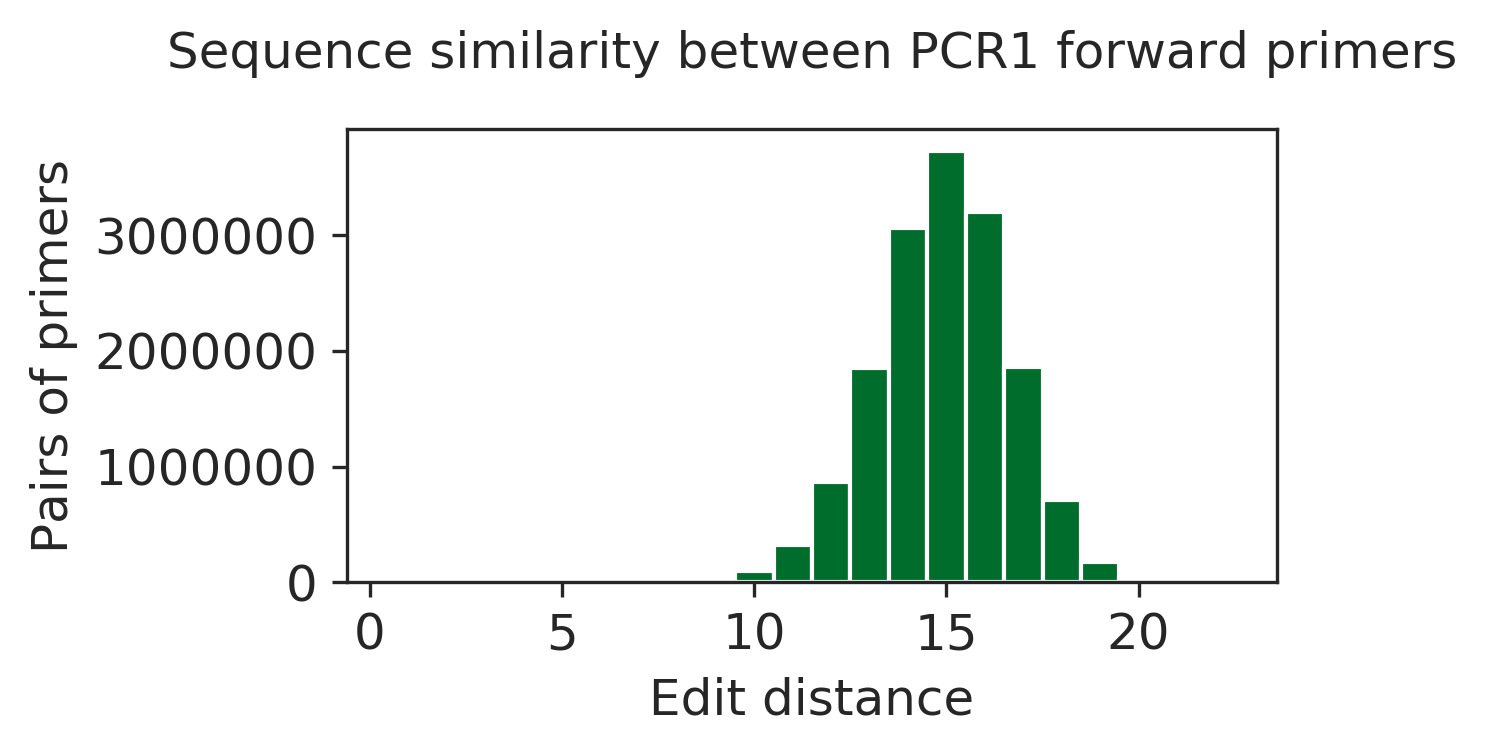

In [35]:
# Distribution of pairwise distances

palette = ["#006d2c", "#a63603", "#54278f", "#74c476", "#fd8d3c", "#9e9ac8"]

x = D[np.triu_indices(len(D), k=1)] # get upper triangular values (non-self comparisons)
bins = np.linspace(0, 22, 23) + 0.5
fig, ax = plt.subplots(1, 1, figsize=(4,2))
ax.hist(x, bins=bins, color=palette[0])
ax.set_xlabel("Edit distance")
ax.set_ylabel("Pairs of primers")
ax.set_title("Sequence similarity between PCR1 forward primers", y=1.08)

8.0 7.91216575172658 0.9889091188853627


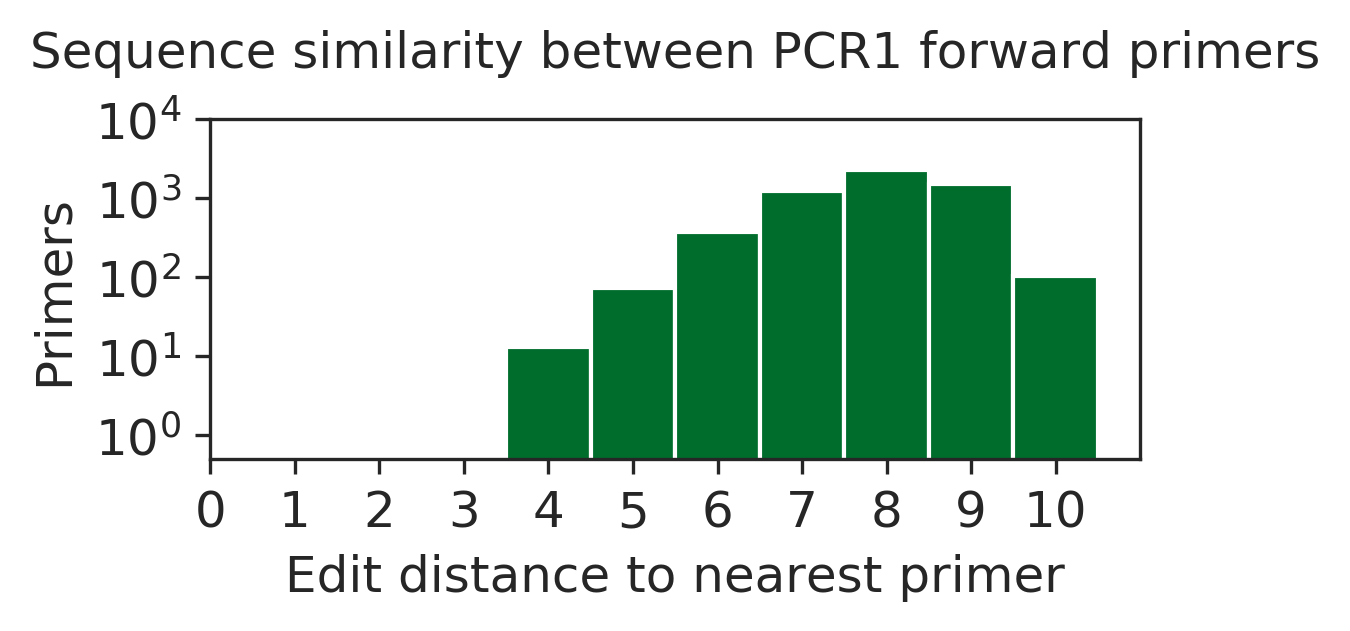

In [36]:
# Distribution of nearest neighbor distances

palette = ["#006d2c", "#a63603", "#54278f", "#74c476", "#fd8d3c", "#9e9ac8"]

x = np.nanmin(D, axis=0) # get nearest neighbor distance
bins = np.linspace(0, 10, 11) + 0.5
fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
ax.hist(x, bins=bins, color=palette[0])
ax.set_yscale("log")
ax.set_ylim(bottom=0.5, top=1e4)
ax.set_xticks(np.arange(0,11))
ax.set_yticks([1, 10, 1e2, 1e3, 1e4])
ax.set_xlabel("Edit distance to nearest primer")
ax.set_ylabel("Primers")
ax.set_title("Sequence similarity between PCR1 forward primers", y=1.08)
print np.median(x), np.mean(x), np.std(x)

save_figure(fig, "SPAR_PCR1_primer_similarity_min")

# Visualize more properties of SPAR primers

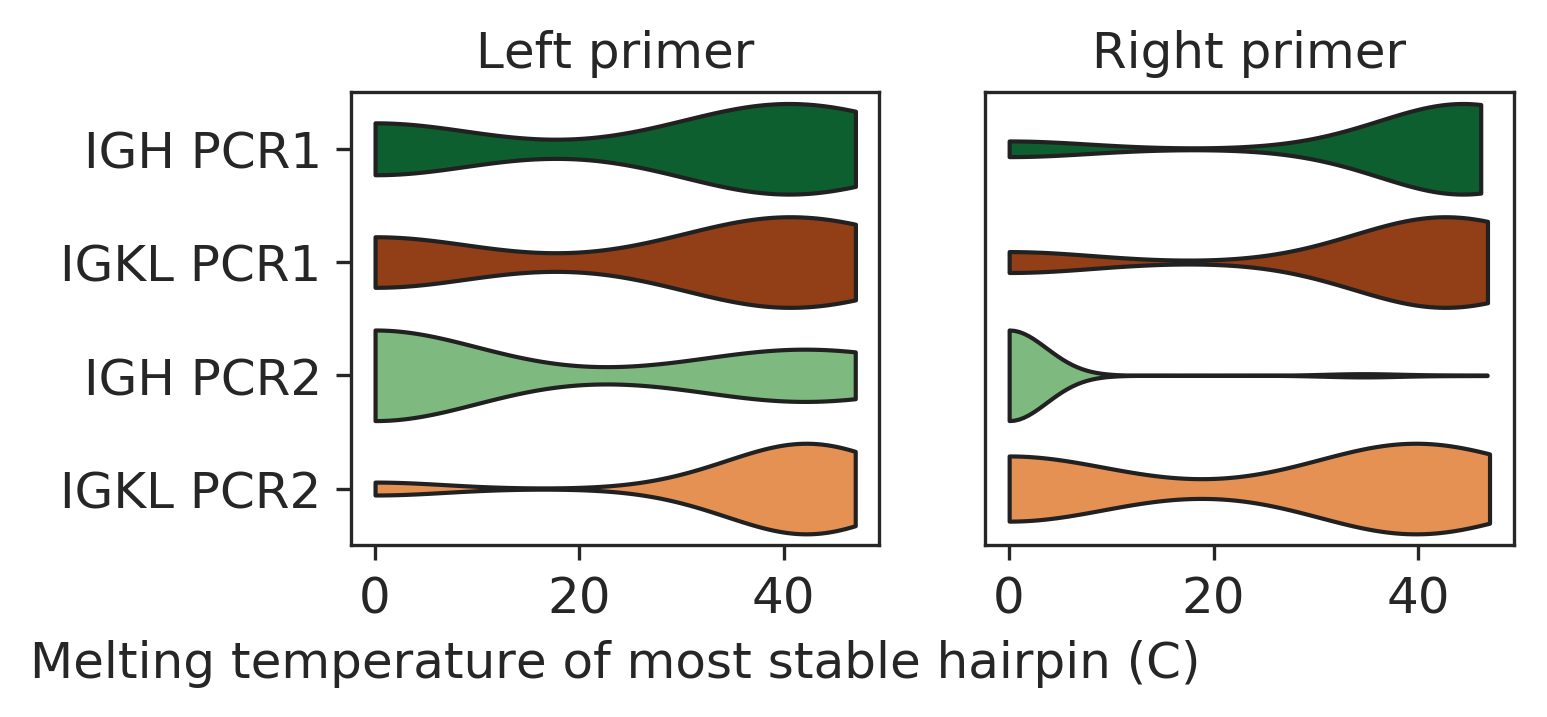

In [37]:
# hairpin_th

palette = [color[0], color[1], color[3], color[4]]

fig, axes = plt.subplots(1, 2, figsize=(5,2))

x1 = df_primers["IGH_pcr1_left_hairpin_th"]
x2 = df_primers["IGKL_pcr1_left_hairpin_th"]
x3 = df_primers["IGH_pcr2_left_hairpin_th"]
x4 = df_primers["IGKL_pcr2_left_hairpin_th"]
data = [x1, x2, x3, x4]

ax = axes[0]
sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

x1 = df_primers["IGH_pcr1_right_hairpin_th"]
x2 = df_primers["IGKL_pcr1_right_hairpin_th"]
x3 = df_primers["IGH_pcr2_right_hairpin_th"]
x4 = df_primers["IGKL_pcr2_right_hairpin_th"]
data2 = [x1, x2, x3, x4]

ax = axes[1]
sns.violinplot(ax=ax, data=data2, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

axes[0].set_title("Left primer")
axes[1].set_title("Right primer")

yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
axes[0].set_yticklabels(yticklabels)
axes[1].set_yticks([])

axes[0].set_xlabel("Melting temperature of most stable hairpin (C)")

save_figure(fig, "SPAR_hairpin_th")

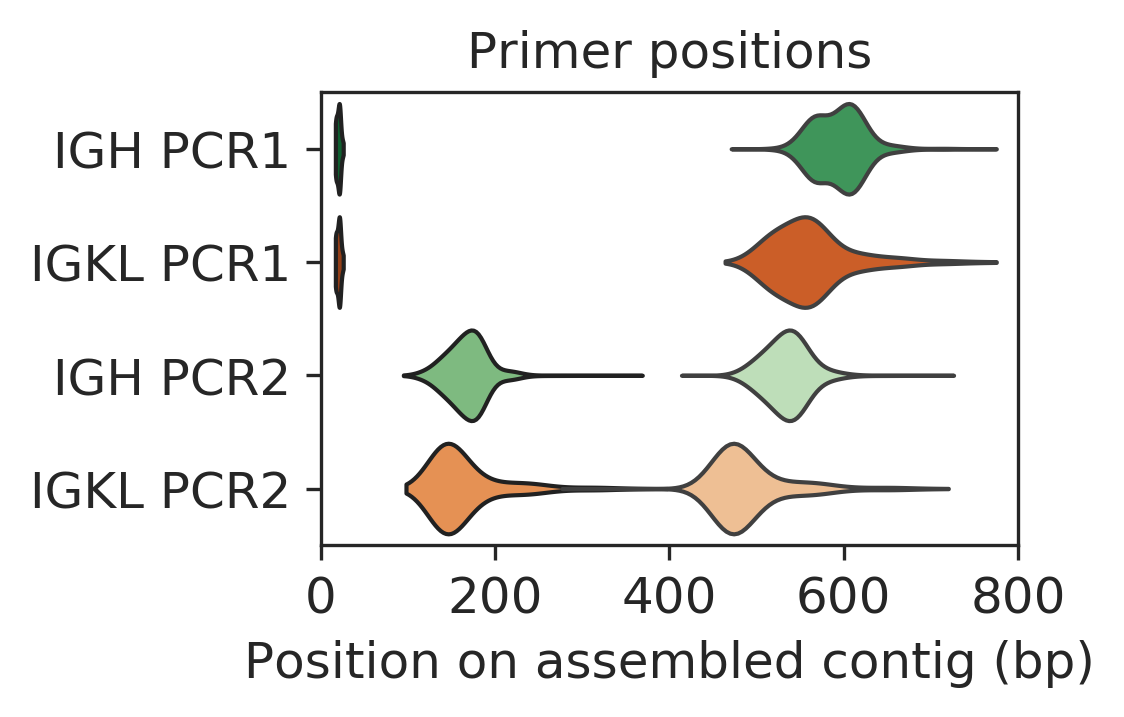

In [38]:
# Position

fig, ax = plt.subplots(1, 1, figsize=(3,2))

x1 = df_primers["IGH_pcr1_left_position"]
x2 = df_primers["IGKL_pcr1_left_position"]
x3 = df_primers["IGH_pcr2_left_position"]
x4 = df_primers["IGKL_pcr2_left_position"]
data = [x1, x2, x3, x4]

palette = [color[0], color[1], color[3], color[4]]
sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

x1 = df_primers["IGH_pcr1_right_position"]
x2 = df_primers["IGKL_pcr1_right_position"]
x3 = df_primers["IGH_pcr2_right_position"]
x4 = df_primers["IGKL_pcr2_right_position"]
data2 = [x1, x2, x3, x4]

palette = ['#31a354', '#e6550d', '#bae4b3', '#fdbe85']
sns.violinplot(ax=ax, data=data2, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)
ax.set_xlim(0, 800)

ax.set_title("Primer positions")
ax.set_xlabel("Position on assembled contig (bp)")
yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
ax.set_yticklabels(yticklabels)

save_figure(fig, "SPAR_primer_positions")

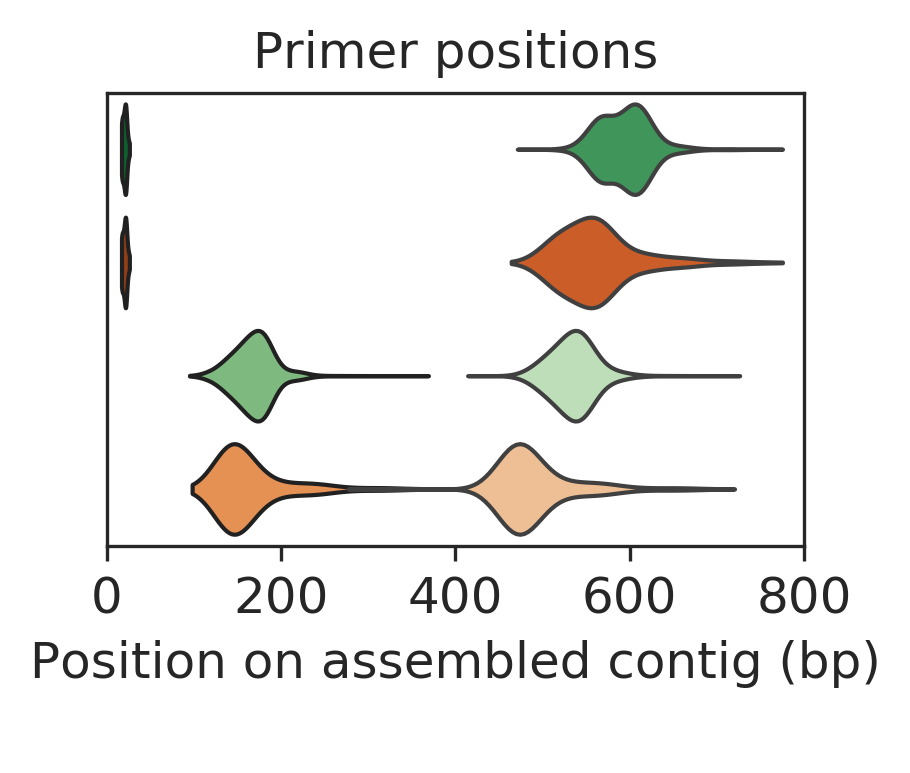

In [39]:
# Position

fig, ax = plt.subplots(1, 1, figsize=(3,2))

x1 = df_primers["IGH_pcr1_left_position"]
x2 = df_primers["IGKL_pcr1_left_position"]
x3 = df_primers["IGH_pcr2_left_position"]
x4 = df_primers["IGKL_pcr2_left_position"]
data = [x1, x2, x3, x4]

palette = [color[0], color[1], color[3], color[4]]
sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)

x1 = df_primers["IGH_pcr1_right_position"]
x2 = df_primers["IGKL_pcr1_right_position"]
x3 = df_primers["IGH_pcr2_right_position"]
x4 = df_primers["IGKL_pcr2_right_position"]
data2 = [x1, x2, x3, x4]

palette = ['#31a354', '#e6550d', '#bae4b3', '#fdbe85']
sns.violinplot(ax=ax, data=data2, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)
ax.set_xlim(0, 800)

ax.set_title("Primer positions")
ax.set_xlabel("Position on assembled contig (bp)\n ")
# yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
ax.set_yticks([])

save_figure(fig, "SPAR_primer_positions_noyticklabels")

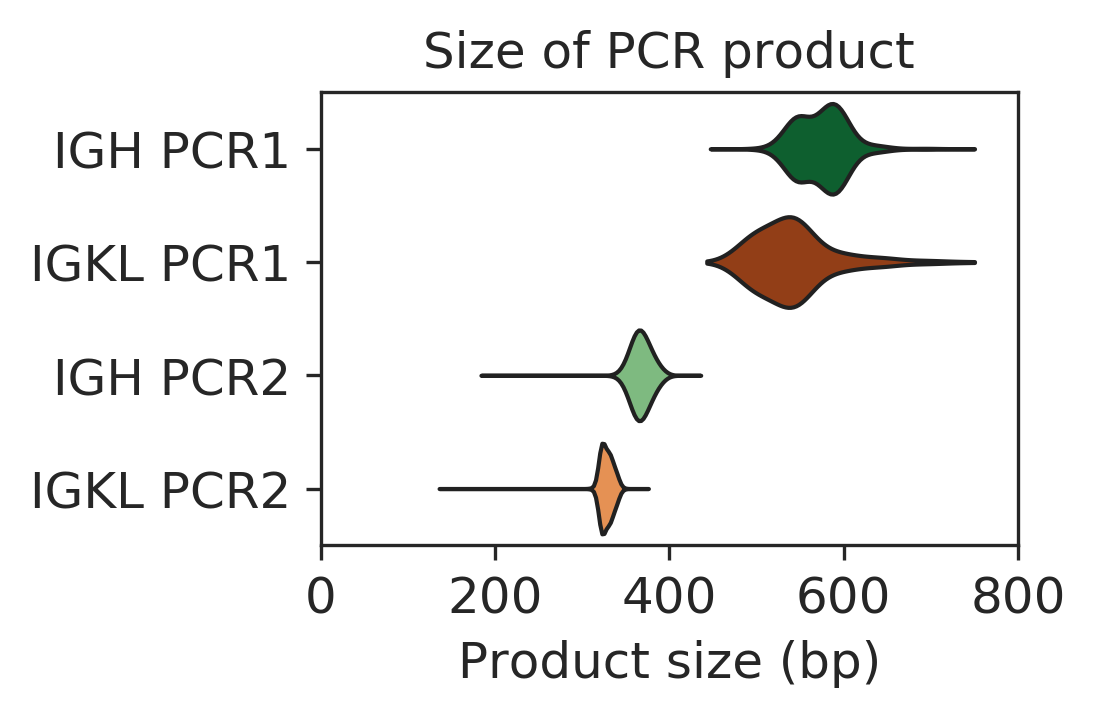

In [40]:
# Size

palette = [color[0], color[1], color[3], color[4]]

fig, ax = plt.subplots(1, 1, figsize=(3,2))

x1 = df_primers["IGH_pcr1_pair_product_size"]
x2 = df_primers["IGKL_pcr1_pair_product_size"]
x3 = df_primers["IGH_pcr2_pair_product_size"]
x4 = df_primers["IGKL_pcr2_pair_product_size"]
data = [x1, x2, x3, x4]

sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)
ax.set_xlim(0, 800)

ax.set_title("Size of PCR product")
ax.set_xlabel("Product size (bp)")
yticklabels = ["IGH PCR1", "IGKL PCR1", "IGH PCR2", "IGKL PCR2"]
ax.set_yticklabels(yticklabels)

save_figure(fig, "SPAR_product_size")

# Molecules per contig

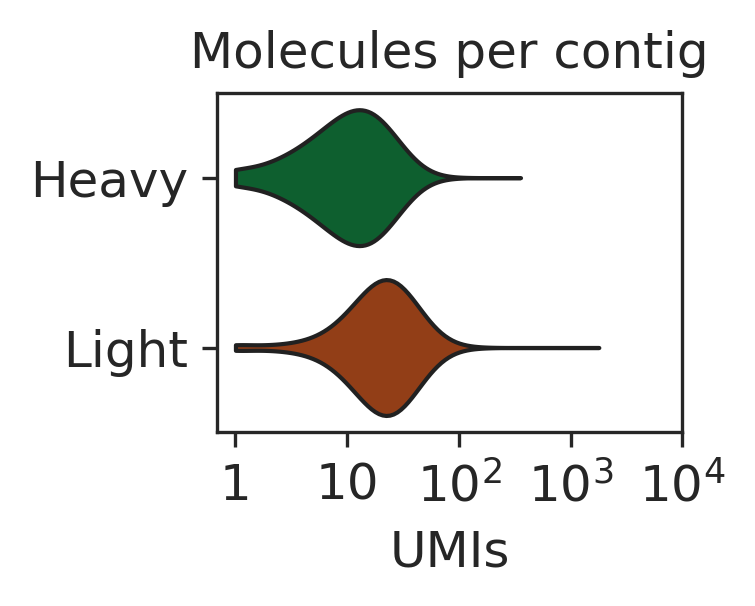

In [41]:
# UMIs per contig

palette = [color[0], color[1], color[3], color[4]]

fig, ax = plt.subplots(1, 1, figsize=(2,1.5))

x1 = np.log10(df_primers["umis_IGH"])
x2 = np.log10(df_primers["umis_IGKL"])
data = [x1, x2]

sns.violinplot(ax=ax, data=data, orient="h", cut=0, bw=0.5, inner=None, scale="width", linewidth=1, palette=palette)
ax.set_xlim(right=4)

ax.set_title("Molecules per contig")
ax.set_xlabel("UMIs")
ax.set_xticks([0, 1, 2, 3, 4])
xticklabels = [1, 10, "$10^2$", "$10^3$", "$10^4$"]
ax.set_xticklabels(xticklabels)
yticklabels = ["Heavy", "Light"]
ax.set_yticklabels(yticklabels)



save_figure(fig, "SPAR_UMIs_per_contig")

In [42]:
# Report median UMIs per contig
print np.median(df_primers["umis_IGH"])
print np.median(df_primers["umis_IGKL"])

11.0
21.0
